# KFP + Feast Demo

1. Pulling latest ticker data daily
2. Materializing it into SQLite
3. Transforming it and uploading it to online store
4. Training model automatically in a pipeline
5. Serving online
6. Web App to ask for should I buy?
 - This should call the online model to get a score and
    if the score > 0.7 return "no"


In [50]:
pip install pandas 


[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [197]:
import os
import pickle
import requests
import datetime
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from polygon import RESTClient

%matplotlib inline

In [12]:
POLYGON_API_KEY = os.environ["POLYGON_API_KEY"]
client = RESTClient(POLYGON_API_KEY)

In [205]:
ndx_ticker = 'I:NDX'
start_date = '2024-01-02'
todays_date = datetime.datetime.now().date().strftime('%Y-%m-%d')
output_filename = 'ticker_data.pkl'

# Pull Nasdaq-100

In [68]:
def get_daily_data(ticker: str="I:NDX") -> pd.DataFrame:
    """
    Return daily data for all of 2024
    """
    daily_ticker_data = []
    for ticker_agg in client.list_aggs(ticker = ticker, from_=start_date, to=todays_date, multiplier=1, timespan="day"):
        daily_ticker_data.append(ticker_agg)

    df = pd.DataFrame(daily_ticker_data)
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df['date'] = df['timestamp'].dt.date
    return df

In [69]:
ndx_df = get_daily_data(ndx_ticker)

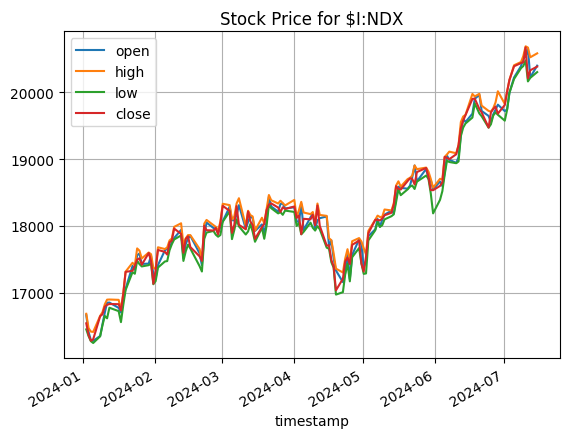

In [70]:
ndx_df.set_index("timestamp")[['open', 'high', 'low', 'close']].plot(grid=True, title=f'Stock Price for ${ndx_ticker}')
plt.show()

# The Magnificent Seven

In [63]:
stock_list = [
    'AAPL',
    'AMZN',
    'GOOG',
    'GOOGL',
    'META',
    'MSFT',
    'NVDA',
    'TSLA',
]

In [312]:
if output_filename in os.listdir():
    with open('ticker_data.pkl', 'rb') as output_file:
        df_dict = pickle.load(output_file)
else:
    df_dict = {ndx_ticker: ndx_df}
    for ticker in stock_list:
        df_dict[ticker] = get_daily_data(ticker)
        time.sleep(30)

    with open('ticker_data.pkl', 'wb') as output_file:
        pickle.dump(df_dict, output_file)                

# Feature Pipeline

In [310]:
def generate_lag_features(df: pd.DataFrame, column: str, n_lags: int=5) -> None:
    for t in range(1, n_lags + 1):
        df[f'{column}_lag{t}'] = df[f'{column}'].shift(t)

def calculate_sliding_window_averages(df: pd.DataFrame, field_name: str, max_window_size: int=5) -> None:
    for window_size in range(1, max_window_size + 1):
        for i in range(1, max_window_size -  window_size + 1):
            column_name = f"{field_name}_window_avg_from_{i}_to_{i+window_size}"
            columns_to_window = [f'{field_name}_lag{c}' for c in range(i, i + window_size + 1)]
            df[column_name] = df[columns_to_window].mean(axis=1)

def feature_pipeline(df: pd.DataFrame, features: list[str], n_lags: int=5, max_window_size: int=5) -> None:
    for c in features:
        generate_lag_features(df, c, n_lags)
        calculate_sliding_window_averages(df, c, max_window_size)

# Join Data into Training Dataset

In [388]:
def create_model_dataset(
    df: pd.DataFrame, 
    main_ticker: str, 
    columns_to_process: list[str], 
    ticker_df_dict: dict, 
    n_lags: int, 
    max_window_size: int
) -> pd.DataFrame:
    finaldf = df.copy()
    feature_pipeline(df, columns_to_process, n_lags, max_window_size)
    finaldf.columns = [f"{c}_{main_ticker.lower()}" for c in finaldf.columns]
    
    for ticker in ticker_df_dict:
        if ticker != main_ticker:
            feature_pipeline(ticker_df_dict[ticker], columns_to_process, n_lags, max_window_size)
            finaldf = finaldf.merge(
                ticker_df_dict[ticker].rename(
                    columns={c:f"{c}_{ticker.lower()}" for c in ticker_df_dict[ticker].columns},
                ), 
                how='left', 
                left_on=f'date_{main_ticker.lower()}',
                right_on=f'date_{ticker.lower()}',
            )    
    return finaldf

In [407]:
finaldf = create_model_dataset(ndx_df, 'I:NDX', ['open', 'low', 'high'], df_dict, 5, 5)

In [408]:
len(list(finaldf.columns))

495

# Now we're just going to use a simple model to predict the close price

In [409]:
feature_list = sorted([c for c in finaldf.columns if ('lag_' in c or 'window_' in c) and 'ndx' not in c])

In [410]:
print(finaldf[feature_list].shape)

(134, 240)


In [412]:
finaldf[['date_i:ndx', 'open_i:ndx'] + feature_list].head()

,date_i:ndx,open_i:ndx,high_window_avg_from_1_to_2_aapl,high_window_avg_from_1_to_2_amzn,high_window_avg_from_1_to_2_goog,high_window_avg_from_1_to_2_googl,high_window_avg_from_1_to_2_meta,high_window_avg_from_1_to_2_msft,high_window_avg_from_1_to_2_nvda,high_window_avg_from_1_to_2_tsla,...,open_window_avg_from_3_to_5_nvda,open_window_avg_from_3_to_5_tsla,open_window_avg_from_4_to_5_aapl,open_window_avg_from_4_to_5_amzn,open_window_avg_from_4_to_5_goog,open_window_avg_from_4_to_5_googl,open_window_avg_from_4_to_5_meta,open_window_avg_from_4_to_5_msft,open_window_avg_from_4_to_5_nvda,open_window_avg_from_4_to_5_tsla
0,2024-01-02,16667.298925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-03,16413.255429,188.4400,152.380,140.61470,139.4500,353.16000,375.9000,49.29500,251.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-04,16290.775018,187.1600,151.715,140.85235,139.5400,350.55500,374.5781,48.73955,248.4650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-05,16281.744368,184.4836,149.215,140.86250,139.3950,348.04995,373.1781,48.34205,244.1900,...,49.2440,250.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-08,16354.220720,182.9236,146.985,139.72250,138.1579,350.82495,372.5800,49.02350,241.4098,...,48.3645,247.53,187.15,151.54,139.6,138.55,351.32,373.86,49.244,250.08


In [413]:
finaldf[feature_list].head()

,high_window_avg_from_1_to_2_aapl,high_window_avg_from_1_to_2_amzn,high_window_avg_from_1_to_2_goog,high_window_avg_from_1_to_2_googl,high_window_avg_from_1_to_2_meta,high_window_avg_from_1_to_2_msft,high_window_avg_from_1_to_2_nvda,high_window_avg_from_1_to_2_tsla,high_window_avg_from_1_to_3_aapl,high_window_avg_from_1_to_3_amzn,...,open_window_avg_from_3_to_5_nvda,open_window_avg_from_3_to_5_tsla,open_window_avg_from_4_to_5_aapl,open_window_avg_from_4_to_5_amzn,open_window_avg_from_4_to_5_goog,open_window_avg_from_4_to_5_googl,open_window_avg_from_4_to_5_meta,open_window_avg_from_4_to_5_msft,open_window_avg_from_4_to_5_nvda,open_window_avg_from_4_to_5_tsla
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.4400,152.380,140.61470,139.4500,353.16000,375.9000,49.29500,251.2500,188.440000,152.380,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,187.1600,151.715,140.85235,139.5400,350.55500,374.5781,48.73955,248.4650,187.160000,151.715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,184.4836,149.215,140.86250,139.3950,348.04995,373.1781,48.34205,244.1900,185.802400,150.270,...,49.2440,250.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,182.9236,146.985,139.72250,138.1579,350.82495,372.5800,49.02350,241.4098,183.909067,148.340,...,48.3645,247.53,187.15,151.54,139.6,138.55,351.32,373.86,49.244,250.08


In [414]:
# Note we start from n_lags because data will be missing
features = torch.from_numpy(finaldf[feature_list].values[n_lags:,:].astype(np.float32))
labels =  torch.from_numpy(finaldf['open_i:ndx'].values[n_lags:].astype(np.float32))

# Inspect the data

In [415]:
features[0:5,:], labels[0:5]

(tensor([[184.1800, 147.9950, 139.7250,  ..., 371.4350,  48.3645, 247.5300],
         [185.3750, 150.5550, 141.7199,  ..., 369.8375,  47.6260, 242.1150],
         [185.7750, 153.0650, 143.6624,  ..., 369.8175,  48.1145, 238.0550],
         [186.7250, 155.7950, 145.5925,  ..., 369.1350,  48.9870, 236.5000],
         [186.8950, 156.6850, 145.7000,  ..., 370.6550,  50.9565, 237.1250]]),
 tensor([16531.9609, 16702.5527, 16852.1895, 16855.0039, 16775.0977]))

# Train the model

In [337]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = features.shape[1]  # Number of features
hidden_size = 32  # Number of hidden units
output_size = 1  # Number of output units

model = SimpleNN(input_size, hidden_size, output_size)

In [338]:
# Hyperparameters
learning_rate = 0.1
num_epochs = 200

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Forward pass
    outputs = model(features)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

Epoch [10/200], Loss: 8812618.0000
Epoch [20/200], Loss: 9939921.0000
Epoch [30/200], Loss: 5652858.5000
Epoch [40/200], Loss: 2765796.0000
Epoch [50/200], Loss: 1981345.7500
Epoch [60/200], Loss: 2052167.6250
Epoch [70/200], Loss: 1800357.7500
Epoch [80/200], Loss: 1732464.7500
Epoch [90/200], Loss: 1653458.0000
Epoch [100/200], Loss: 1577163.2500
Epoch [110/200], Loss: 1510691.7500
Epoch [120/200], Loss: 1451053.7500
Epoch [130/200], Loss: 1397547.5000
Epoch [140/200], Loss: 1350160.5000
Epoch [150/200], Loss: 1308856.0000
Epoch [160/200], Loss: 1273397.0000
Epoch [170/200], Loss: 1243356.2500
Epoch [180/200], Loss: 1218122.3750
Epoch [190/200], Loss: 1196999.6250
Epoch [200/200], Loss: 1179281.5000
Training complete.


/Users/farceo/dev/Python/demos/kfp-demos/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([129])) that is different to the input size (torch.Size([129, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [417]:
type(labels)

torch.Tensor

In [339]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(features)

In [340]:
print(f"RMSE = {torch.sqrt( torch.mean( (predictions- labels) ** 2) )}")

RMSE = 1085.205322265625


In [342]:
finaldf['predictions'] = None
finaldf.loc[n_lags:,'predictions'] = predictions

In [345]:
torch.save(model.state_dict(), "ndx_model_weights.pth")

In [365]:
df_directory = "data"
if not os.path.exists(df_directory):
    os.makedirs(df_directory)

In [366]:
finaldf.to_parquet(os.path.join(df_directory, "historical_extract.parquet"))

# Pulling New data

In [ ]:
# Save two versions: (1) snapshot and (2) total historical

In [368]:
historical_df = pd.read_parquet(os.path.join(df_directory, "historical_extract.parquet"))

In [369]:
historical_df

,open_ndx,high_ndx,low_ndx,close_ndx,volume_ndx,vwap_ndx,timestamp_ndx,transactions_ndx,otc_ndx,date_ndx,...,high_window_avg_from_2_to_3_amzn,high_window_avg_from_3_to_4_amzn,high_window_avg_from_4_to_5_amzn,high_window_avg_from_1_to_3_amzn,high_window_avg_from_2_to_4_amzn,high_window_avg_from_3_to_5_amzn,high_window_avg_from_1_to_4_amzn,high_window_avg_from_2_to_5_amzn,high_window_avg_from_1_to_5_amzn,predictions
0,16667.298925,16686.603502,16453.150303,16543.937606,None,None,2024-01-02 06:00:00,None,None,2024-01-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16413.255429,16471.076838,16352.142018,16368.490570,None,None,2024-01-03 06:00:00,None,None,2024-01-03,...,NaN,NaN,NaN,152.380000,NaN,NaN,152.380000,NaN,152.38000,NaN
2,16290.775018,16419.438173,16276.431012,16282.012409,None,None,2024-01-04 06:00:00,None,None,2024-01-04,...,152.38000,NaN,NaN,151.715000,152.380000,NaN,151.715000,152.380000,151.71500,NaN
3,16281.744368,16415.392538,16249.189041,16305.979061,None,None,2024-01-05 06:00:00,None,None,2024-01-05,...,151.71500,152.3800,NaN,150.270000,151.715000,152.380000,150.270000,151.715000,150.27000,NaN
4,16354.220720,16655.231025,16349.390334,16649.874274,None,None,2024-01-08 06:00:00,None,None,2024-01-08,...,149.21500,151.7150,152.38000,148.340000,150.270000,151.715000,149.350000,150.270000,149.35000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,20504.173451,20543.902898,20395.572412,20453.024024,None,None,2024-07-09 05:00:00,None,None,2024-07-09,...,200.28950,200.2295,199.36285,200.593000,200.336333,199.584900,200.552250,199.826175,200.10094,20086.212891
130,20533.270853,20690.966399,20479.942609,20675.378624,None,None,2024-07-10 05:00:00,None,None,2024-07-10,...,200.87500,200.2895,200.22950,200.773333,200.593000,200.336333,200.587250,200.552250,200.55580,20407.896484
131,20661.413262,20672.101811,20165.004073,20211.359519,None,None,2024-07-11 05:00:00,None,None,2024-07-11,...,200.88500,200.8750,200.28950,200.626667,200.773333,200.593000,200.607500,200.587250,200.49180,20613.501953
132,20226.234405,20526.084478,20217.993200,20331.493595,None,None,2024-07-12 05:00:00,None,None,2024-07-12,...,200.34000,200.8850,200.87500,200.316633,200.626667,200.773333,200.537475,200.607500,200.53998,20693.798828
